In [1]:
%matplotlib inline
from __future__ import print_function, division
import sys, os
import json
import math
import numpy as np
import itertools, collections
import datetime as dt

In [2]:
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster")
#sns.set_context("talk", font_scale=1.4)

In [4]:
import geopandas as gp
import pandas as pd

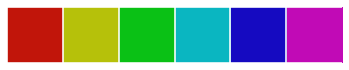

In [5]:
current_palette = sns.color_palette(sns.hls_palette(6, l=.4, s=.9))
sns.set_palette(current_palette)
sns.palplot(current_palette)
palette = itertools.cycle(sns.color_palette())

We use Alaska Albers shapefiles all around to be able to measure distances in metres. The WGS84 shapefiles from AICC and the Forest Service Active Fire Maps web portal were converted using GDAL: 

`ogr2ogr -f "ESRI Shapefile" outfile_AKAlbers.shp infile.shp -s_srs EPSG:4326 -t_SRS EPSG:3338` 

### Data loading - remotely sensed hotspots

Active fire hotspots from activefiremaps.fs.fed.us:

In [6]:
datadir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/10_intermediate_products/"
mod14shp = "2016MOD14_Perims_AKAlbers_5km.shp"
viirsIshp = "2016VIIRSI_Perims_AKAlbers_5km.shp"

In [7]:
mod14DF = gp.GeoDataFrame.from_file(os.path.join(datadir, mod14shp))
viirsIDF = gp.GeoDataFrame.from_file(os.path.join(datadir, viirsIshp))

### Output settings

In [8]:
gisoutdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/'

### Investigate times of hotspots - throughout the fire season and time-of-day

In [9]:
def get_time_AKDT(row):
    return get_time_AKDT_twoargs_asstring(row['ACQ_DATE'], row['ACQ_TIME'])

def get_time_AKDT_twoargs_asstring(datearg, timearg):
    datest = dt.datetime.strptime(datearg + str(timearg).zfill(4), "%Y-%m-%d%H%M")
    datest -= dt.timedelta(hours=8)
    return datest.strftime('%H%M')

def get_time_AKDT_twoargs_asnum(datearg, timearg):
    return int(get_time_AKDT_twoargs_asstring(datearg, timearg))

viirsIAKDTtimes = viirsIDF.apply(lambda row: int(get_time_AKDT(row)), axis=1)
mod14AKDTtimes = mod14DF.apply(lambda row: int(get_time_AKDT(row)), axis=1)

In [10]:
viirsIDF['AKDT'] = map(get_time_AKDT_twoargs_asnum, viirsIDF['ACQ_DATE'], viirsIDF['ACQ_TIME'])
mod14DF['AKDT'] = map(get_time_AKDT_twoargs_asnum, mod14DF['ACQ_DATE'], mod14DF['ACQ_TIME'])

In [11]:
mod14DF['DateTime'] = pd.to_datetime(mod14DF['ACQ_DATE'] + ' ' + mod14DF['ACQ_TIME'].apply(
        lambda a: str(a).zfill(4)), format='%Y-%m-%d %H%M')
mod14DF = mod14DF.set_index('DateTime')

In [12]:
viirsIDF['DateTime'] = pd.to_datetime(viirsIDF['ACQ_DATE'] + ' ' + viirsIDF['ACQ_TIME'].apply(
        lambda a: str(a).zfill(4)), format='%Y-%m-%d %H%M')
viirsIDF = viirsIDF.set_index('DateTime')

In [13]:
viirsIDF['Julian_AKDT'] = (viirsIDF.index + pd.DateOffset(hours=-8)).strftime('%j').astype('int')
viirsIDF['DATE_AKDT'] = (viirsIDF.index + pd.DateOffset(hours=-8)).strftime('%b %d')
viirsIDF['hour_AKDT'] = (viirsIDF.index + pd.DateOffset(hours=-8)).hour.astype('int')
mod14DF['Julian_AKDT'] = (mod14DF.index + pd.DateOffset(hours=-8)).strftime('%j').astype('int')
mod14DF['DATE_AKDT'] = (mod14DF.index + pd.DateOffset(hours=-8)).strftime('%b %d')
mod14DF['hour_AKDT'] = (mod14DF.index + pd.DateOffset(hours=-8)).hour.astype('int')

In [14]:
cols_test = pd.date_range('2016-03-25', '2016-11-05')

In [15]:
len(cols_test.strftime("%b %d"))

226

In [16]:
viirs_by_day_hour_test = pd.DataFrame(
    np.nan,
    columns=cols_test.strftime("%b %d"),
    index=np.arange(0, 24))

In [17]:
viirs_by_day_hour = viirsIDF['2016-03-25':'2016-11-05'].groupby(
    ['hour_AKDT', 'DATE_AKDT']).size().reset_index(name="count").pivot(
    'hour_AKDT', 'DATE_AKDT', 'count')

In [18]:
viirs_by_day_hour_test.ix[
    viirs_by_day_hour.index, viirs_by_day_hour.columns.tolist()] = viirs_by_day_hour.ix[
    viirs_by_day_hour.index, viirs_by_day_hour.columns.tolist()]

In [19]:
modA_by_day_hour = mod14DF[mod14DF.SATELLITE == 'Aqua']['2016-03-25':'2016-11-05'].groupby(
    ['hour_AKDT', 'DATE_AKDT']).size().reset_index(name="count").pivot(
    'hour_AKDT', 'DATE_AKDT', 'count')
modT_by_day_hour = mod14DF[mod14DF.SATELLITE == 'Terra']['2016-03-25':'2016-11-05'].groupby(
    ['hour_AKDT', 'DATE_AKDT']).size().reset_index(name="count").pivot(
    'hour_AKDT', 'DATE_AKDT', 'count')


In [20]:
modT_by_day_hour_test = pd.DataFrame(
    np.nan,
    columns=cols_test.strftime("%b %d"),
    index=np.arange(0, 24))
modA_by_day_hour_test = pd.DataFrame(
    np.nan,
    columns=cols_test.strftime("%b %d"),
    index=np.arange(0, 24))

In [21]:
modA_by_day_hour_test.ix[
    modA_by_day_hour.index, modA_by_day_hour.columns.tolist()] = modA_by_day_hour.ix[
    modA_by_day_hour.index, modA_by_day_hour.columns.tolist()]
modT_by_day_hour_test.ix[
    modT_by_day_hour.index, modT_by_day_hour.columns.tolist()] = modT_by_day_hour.ix[
    modT_by_day_hour.index, modT_by_day_hour.columns.tolist()]

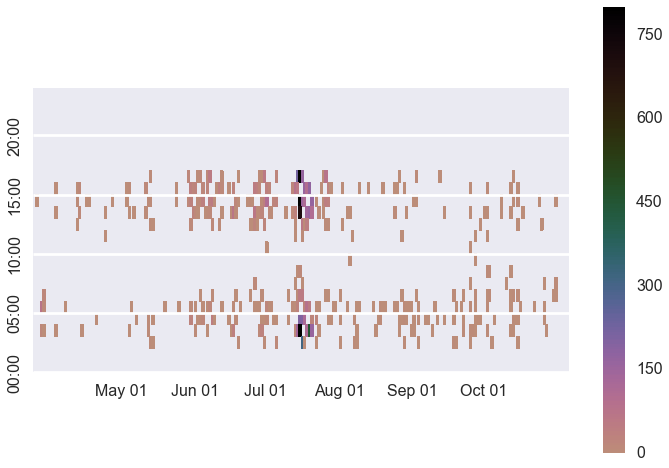

In [22]:
sns.set_style('darkgrid')
cmap = sns.cubehelix_palette(start=.5, rot=2, light=0.6, dark=0, as_cmap=True)
xdatelabels = ['May 01', 'Jun 01', 'Jul 01', 'Aug 01', 'Sep 01', 'Oct 01']
xticks = [np.where(viirs_by_day_hour_test.columns == sampledate)[0][0] for sampledate in xdatelabels]

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    viirs_by_day_hour_test,
    cmap=cmap,
    xticklabels= 20,
    vmin=0,
    vmax=800
#    linewidths=.1
#    cbar_kws={"orientation": "horizontal"}
)
ax.invert_yaxis()
ax.set_yticks([  4, 9, 14, 19, 24])
ax.set_yticklabels(['20:00', '15:00', '10:00', '05:00', '00:00'])
ax.hlines([  4, 9, 14, 19, 24], *ax.get_xlim(), colors='w')
ax.set_xticks(xticks)
ax.set_xticklabels(xdatelabels)
ax.set_aspect(5)

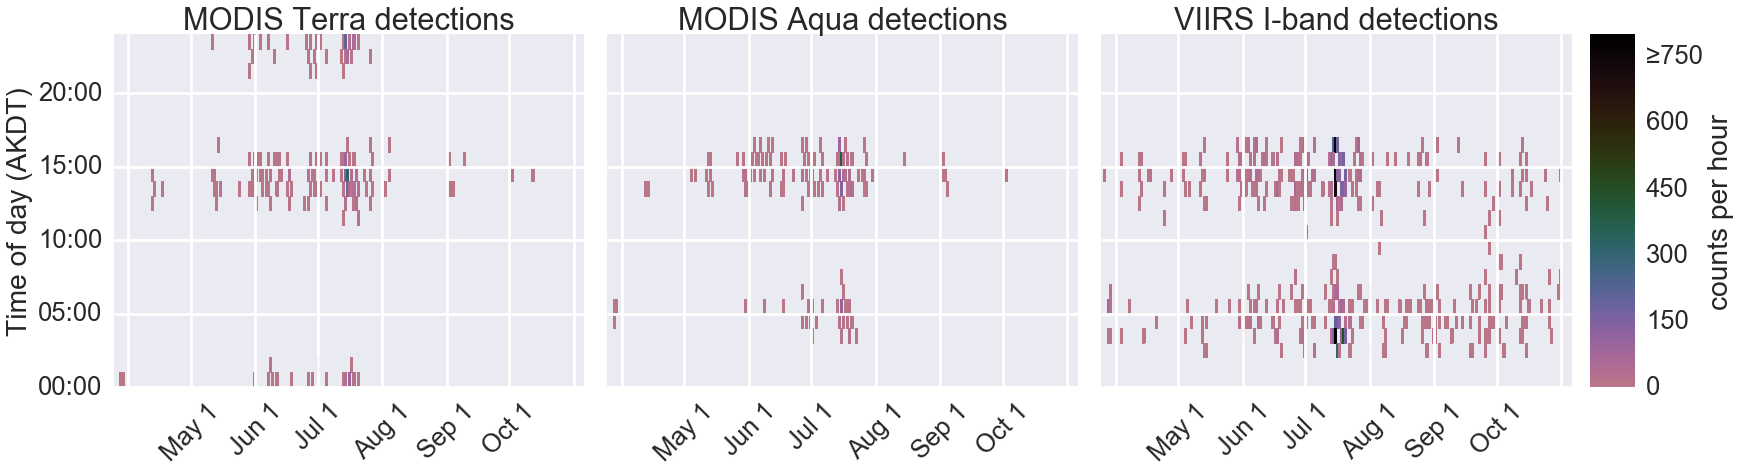

In [103]:
SAVEFIG = False

sns.set_context("poster", font_scale=1.6)
sns.set_style('darkgrid')
cmap = sns.cubehelix_palette(start=.5, rot=2, light=0.55, dark=0, as_cmap=True)
xdatelabels = ['May 1', 'Jun 1', 'Jul 1', 'Aug 1', 'Sep 1', 'Oct 1']
xticks = [37, 68, 98, 129, 160, 190]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(25, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace = 0.05, 
                    right=0.89,
                    left=0.08, 
                    bottom=0.2)
cbar_ax = fig.add_axes([0.9, 0.2, 0.025, 0.7])

sns.heatmap(
    modT_by_day_hour_test,
    cmap=cmap,
    xticklabels= 20,
    vmin=0,
    vmax=800,
    ax=ax0,
    cbar=False
)
sns.heatmap(
    modA_by_day_hour_test,
    cmap=cmap,
    xticklabels= 20,
    vmin=0,
    vmax=800,
    ax=ax1,
    cbar=False
)
sns.heatmap(
    viirs_by_day_hour_test,
    cmap=cmap,
    xticklabels= 20,
    vmin=0,
    vmax=800,
    ax=ax2,
    cbar_ax=cbar_ax,
    cbar_kws={
        'label': 'counts per hour',
         }
)
cbar_ax.set_yticklabels(['0', '150', '300', '450', '600', u'≥750'])

ax0.invert_yaxis()
ax0.set_yticks([  4, 9, 14, 19, 24])
ax0.set_yticklabels(['20:00', '15:00', '10:00', '05:00', '00:00'])
ax0.set_ylabel('Time of day (AKDT)')
for ax in [ax0, ax1, ax2]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xdatelabels, rotation=45)
    ax.set_xlabel('')
    ax.hlines([  4, 9, 14, 19, 24], *ax.get_xlim(), colors='w')
    ax.vlines([7, 37, 68, 98, 129, 160, 190, 221], *ax.get_ylim(), colors='w')

ax0.set_title('MODIS Terra detections')
ax1.set_title('MODIS Aqua detections')
ax2.set_title('VIIRS I-band detections')


In [104]:
outfn = 'Fig06_LR.png'
fig.savefig(os.path.join(gisoutdir, outfn), dpi=200, bb_inches='tight')

In [105]:
outfn = 'Fig06.png'
fig.savefig(os.path.join(gisoutdir, outfn), dpi=400, bb_inches='tight')

In [23]:
xdatelabels = ['May 01', 'Jun 01', 'Jul 01', 'Aug 01', 'Sep 01', 'Oct 01']
xticks = [np.where(viirs_by_day_hour_test.columns == sampledate)[0][0] for sampledate in xdatelabels]
xticks

[37, 68, 98, 129, 160, 190]

In [24]:
daterange = pd.date_range('2016-06', '2016-09', freq='MS')
#daterange.map(lambda x: x.strftime('%m%d'))
datelabels = [x.strftime('%b %-d') for x in daterange]
print(datelabels)

['Jun 1', 'Jul 1', 'Aug 1', 'Sep 1']


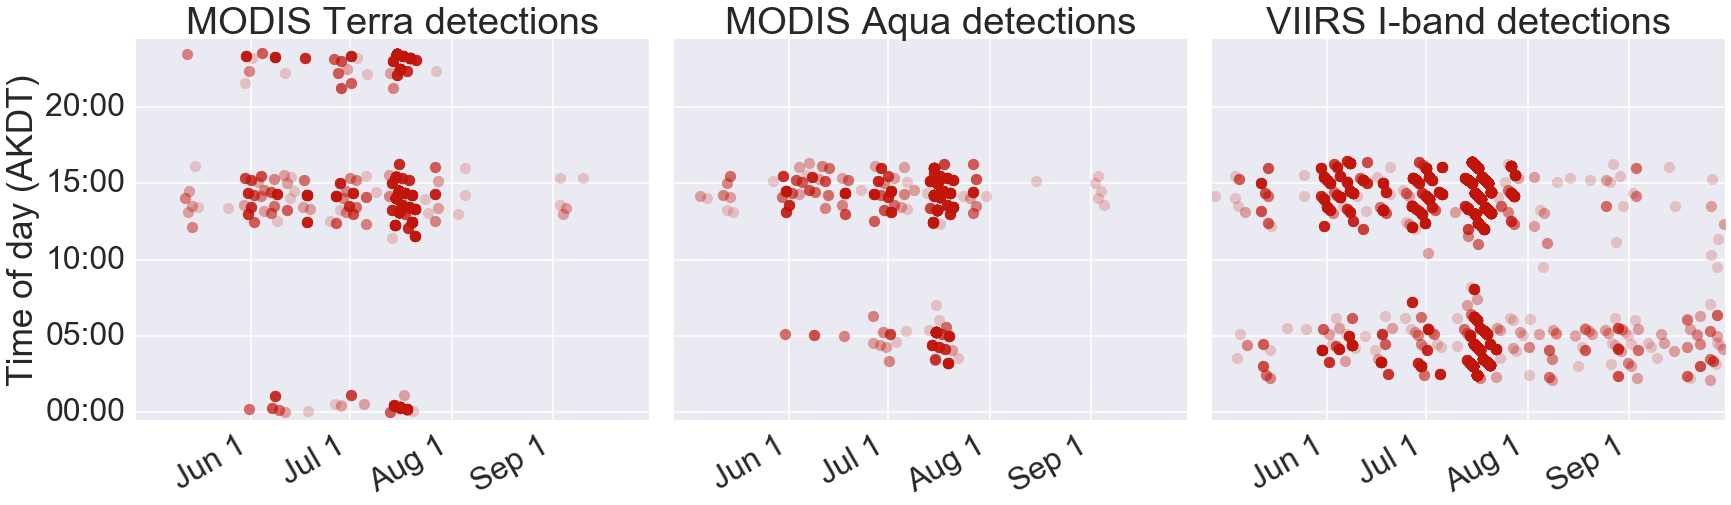

In [25]:
sns.set_context("poster", font_scale=2.0)
SAVEFIG = False

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(25, 8), sharex=True, sharey=True)
pd.tools.plotting.plot_frame(
    mod14DF.loc[mod14DF['SATELLITE'] == 'Terra', 'AKDT']['2016-04-10':'2016-09-30'], 
    marker='o', alpha=0.2, linewidth=0, 
    xlim=('2016-04-27', '2016-09-30'), ylim=(-50, 2450),
    ax=ax0
)
pd.tools.plotting.plot_frame(
    mod14DF.loc[mod14DF['SATELLITE'] == 'Aqua', 'AKDT']['2016-04-10':'2016-09-30'], 
    marker='o', alpha=0.2, linewidth=0,
    xlim=('2016-04-27', '2016-09-30'), ylim=(-50, 2450),
    ax=ax1
)
pd.tools.plotting.plot_frame(
    viirsIDF['AKDT']['2016-04-10':'2016-09-30'], 
    marker='o', alpha=0.2, linewidth=0,
    xlim=('2016-04-27', '2016-09-30'), ylim=(-50, 2450),
    ax=ax2
)
ax0.set_yticklabels(['xxx', '00:00', '05:00', '10:00', '15:00', '20:00'])
ax0.set_ylabel('Time of day (AKDT)')
ax0.set_xticks(daterange)
ax0.set_xticklabels(datelabels)
ax0.set_xlabel('')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax0.set_title('MODIS Terra detections')
ax1.set_title('MODIS Aqua detections')
ax2.set_title('VIIRS I-band detections')
ax0.legend().set_visible(False)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.05)

if SAVEFIG:
    outfn = 'mod_and_viirs_timescatter_AKDT.png'
    plt.savefig(os.path.join(gisoutdir, outfn), dpi=300, bbox_inches='tight')     

In [26]:
viirsIDF['x'] = viirsIDF['geometry'].apply(lambda item: item.x)
viirsIDF['y'] = viirsIDF['geometry'].apply(lambda item: item.y)
mod14DF['x'] = mod14DF['geometry'].apply(lambda item: item.x)
mod14DF['y'] = mod14DF['geometry'].apply(lambda item: item.y)

In [27]:
def get_timeslice(gmttime, hours=6):
    """gmttime is in 'miltary time', between 0 and 2359"""
    hoursdiv = hours * 100
    slc = int(gmttime) // hoursdiv
    return "{}-{}".format(slc*hoursdiv, min((slc+1)*hoursdiv, 2400))

get_timeslice(500, hours=5)
    

'500-1000'

In [28]:
viirsIDF['utcinterval'] = viirsIDF['ACQ_TIME'].apply(get_timeslice, hours=6)
mod14DF['utcinterval'] = mod14DF['ACQ_TIME'].apply(get_timeslice, hours=6)

In [29]:
viirsIDF['akdtinterval'] = viirsIDF['AKDT'].apply(get_timeslice, hours=6)
mod14DF['akdtinterval'] = mod14DF['AKDT'].apply(get_timeslice, hours=6)

In [30]:
cols = ['0-600', '600-1200', '1200-1800', '1800-2400']
#cols = ['0-1200', '1200-2400']

In [31]:
statedf = gp.GeoDataFrame.from_file("/Volumes/SCIENCE_mobile_Mac/GENERAL_GIS/census_gov/cb_2014_us_state_20m/cb_2014_us_state_20m.json")
multipolyAK = statedf[statedf['NAME'] == 'Alaska']['geometry'].to_crs(viirsIDF.crs).values[0]
patches = [PolygonPatch(poly, facecolor=None, alpha=.1) for poly in multipolyAK]

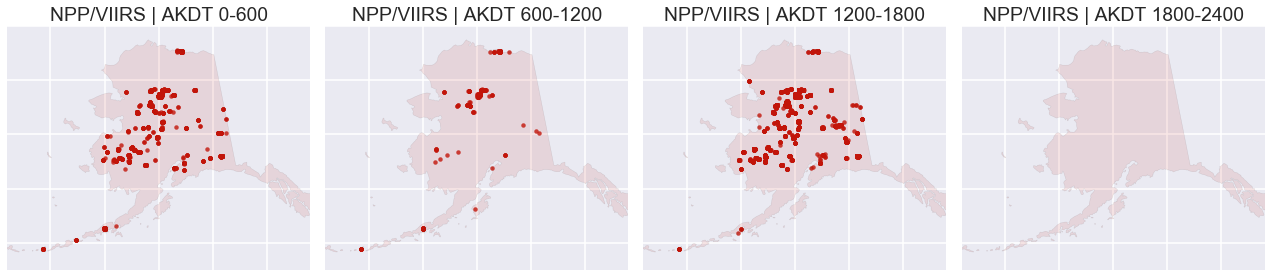

In [73]:
sns.set_context("poster", font_scale=1.1)

SAVEFIG = False
lm = sns.lmplot('x', 'y', col='akdtinterval', data=viirsIDF, col_order=cols, fit_reg=False, aspect=1, legend=False)
lm = (lm.set_titles("NPP/VIIRS | AKDT {col_name}"))
lm.set_xticklabels([])
lm.set_yticklabels([])
lm.set_xlabels('')
lm.set_ylabels('')
plt.subplots_adjust(wspace = 0.05)

axes = lm.axes
for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(-1000000.0, 1000000.0)
    ax.set_ylim(250000, 2500000.0)
    ax.add_collection(PatchCollection(patches, match_original=True))
plt.savefig(os.path.join(gisoutdir, "VIIRSmaps_AKDT.png"), dpi=400, bbox_inches='tight')

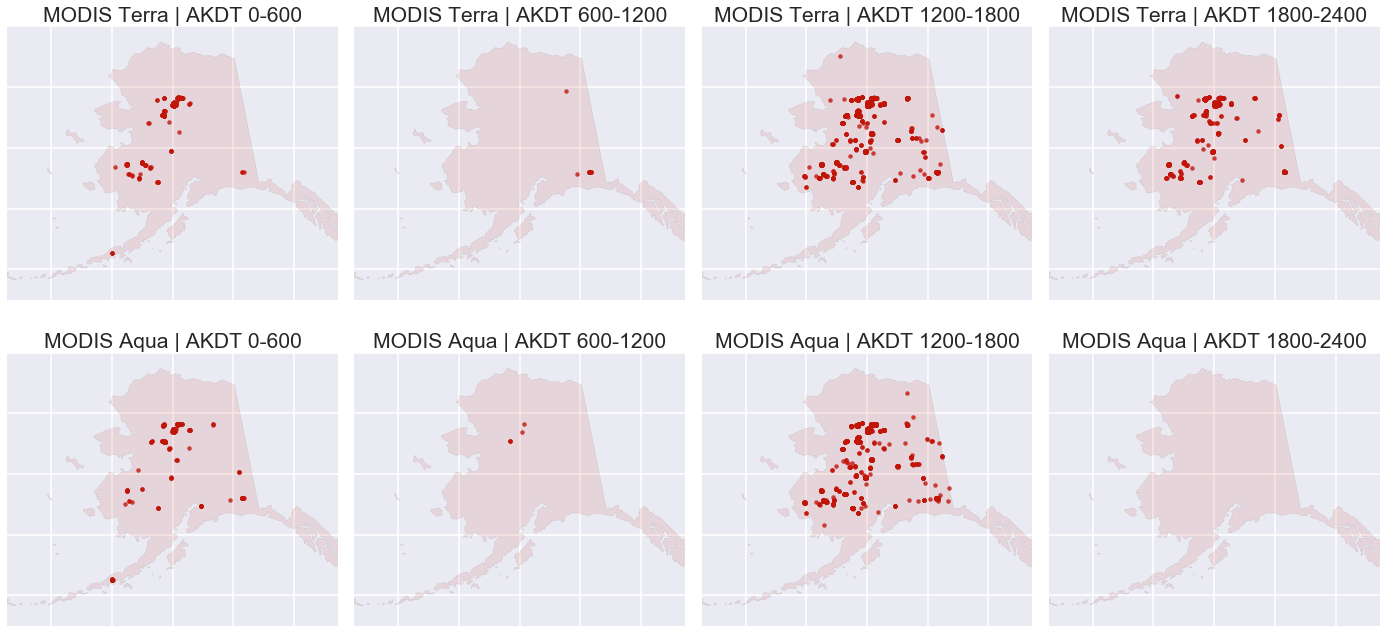

In [72]:
sns.set_context("poster", font_scale=1.2)

SAVEFIG = False
lm = sns.lmplot(
    'x', 'y', col='akdtinterval', row='SATELLITE', 
    col_order=cols, data=mod14DF, fit_reg=False, aspect=1.1, legend=False)
lm = (lm.set_titles("MODIS {row_name} | AKDT {col_name}"))
lm.set_xticklabels([])
lm.set_yticklabels([])
lm.set_xlabels('')
lm.set_ylabels('')
plt.subplots_adjust(wspace = 0.05)

axes = lm.axes
for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(-1000000.0, 1000000.0)
    ax.set_ylim(250000, 2500000.0)
    ax.add_collection(PatchCollection(patches, match_original=True))
plt.savefig(os.path.join(gisoutdir, "VIIRSmaps_AKDT.png"), dpi=400, bbox_inches='tight')

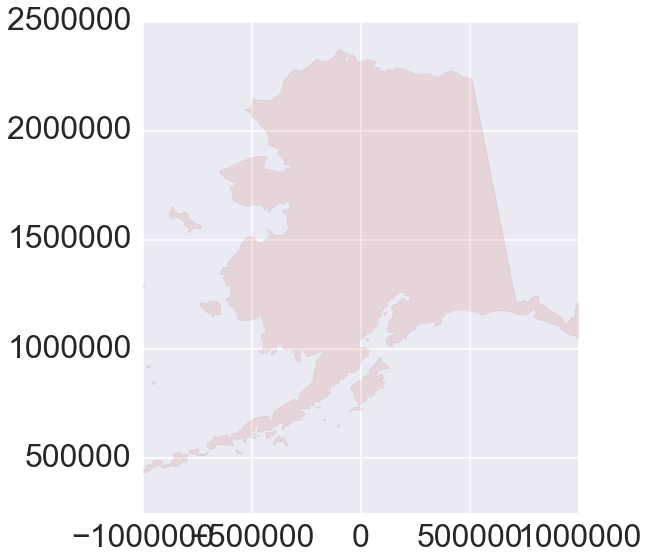

In [34]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-1000000.0, 1000000.0)
ax.set_ylim(250000, 2500000.0)
ax.add_collection(PatchCollection(patches, match_original=True))


## 2D histograms / density plots

In [32]:
import numpy as np
import shapely

In [33]:
multipolyAK = statedf[statedf['NAME'] == 'Alaska']['geometry'].to_crs(viirsIDF.crs).values[0]
patches = [PolygonPatch(poly, facecolor='white', edgecolor='grey') for poly in multipolyAK]    

In [34]:
rest = shapely.geometry.box(-1100000, -1, 1100000, 2500000)
restpatches = PolygonPatch(rest.difference(multipolyAK), facecolor='grey', alpha=.1) 

In [35]:
modTxs = []
modTys = []
modAxs = []
modAys = []
viirsixs = []
viirsiys = []
modThists = []
modAhists = []
viirshists = []
timeslices = ['0-600', '600-1200', '1200-1800', '1800-2400']

In [36]:
xedges = np.arange(-1000000, 1000000, 50000)
yedges = np.arange(0, 2500000, 50000)

In [37]:
for tslice in timeslices:
    modTx =  mod14DF[
                 (mod14DF['akdtinterval'] == tslice) & 
                 (mod14DF['SATELLITE'] == 'Terra')].x.values
    modTy =  mod14DF[
                 (mod14DF['akdtinterval'] == tslice) & 
                 (mod14DF['SATELLITE'] == 'Terra')].y.values        
    modAx =  mod14DF[
                 (mod14DF['akdtinterval'] == tslice) & 
                 (mod14DF['SATELLITE'] == 'Aqua')].x.values
    modAy =  mod14DF[
                 (mod14DF['akdtinterval'] == tslice) & 
                 (mod14DF['SATELLITE'] == 'Aqua')].y.values
    viirsx =  viirsIDF[
                 (viirsIDF['akdtinterval'] == tslice)].x.values
    viirsy =  viirsIDF[
                 (viirsIDF['akdtinterval'] == tslice)].y.values
    modTxs.append(modTx)
    modTys.append(modTy)
    modAxs.append(modAx)
    modAys.append(modAy)   
    viirsixs.append(viirsx)
    viirsiys.append(viirsy)
    hist, _, _ = np.histogram2d(viirsx, viirsy, bins=(xedges, yedges))
    viirshists.append(hist)
    hist, _, _ = np.histogram2d(modAx, modAy, bins=(xedges, yedges))
    modAhists.append(hist)
    hist, _, _ = np.histogram2d(modTx, modTy, bins=(xedges, yedges))
    modThists.append(hist)

In [38]:
X, Y = np.meshgrid(yedges, xedges)

In [39]:
[item.max() for item in viirshists]

[532.0, 50.0, 1179.0, 0.0]

In [40]:
modAtitles = ['M Aqua | AKDT 0-600', 'M Aqua | AKDT 600-1200', 'M Aqua | AKDT 1200-1800', 'M Aqua | AKDT 1800-2400']
modTtitles = ['M Terra | AKDT 0-600', 'M Terra | AKDT 600-1200', 'M Terra | AKDT 1200-1800', 'M Terra | AKDT 1800-2400']
modtitles = ['MODIS | AKDT 0-600', 'MODIS | AKDT 600-1200', 'MODIS | AKDT 1200-1800', 'MODIS | AKDT 1800-2400']
viirstitles = ['VIIRS-I | AKDT 0-600', 'VIIRS-I | AKDT 600-1200', 'VIIRS-I | AKDT 1200-1800', 'VIIRS-I | AKDT 1800-2400']

In [41]:
viirscounts = ['3544', '263', '7284', '0']
modAcounts = ['250', '5', '1416', '0']
modTcounts = ['182', '20', '1390', '506']

In [42]:
X.shape

(40, 50)

In [47]:
del fig

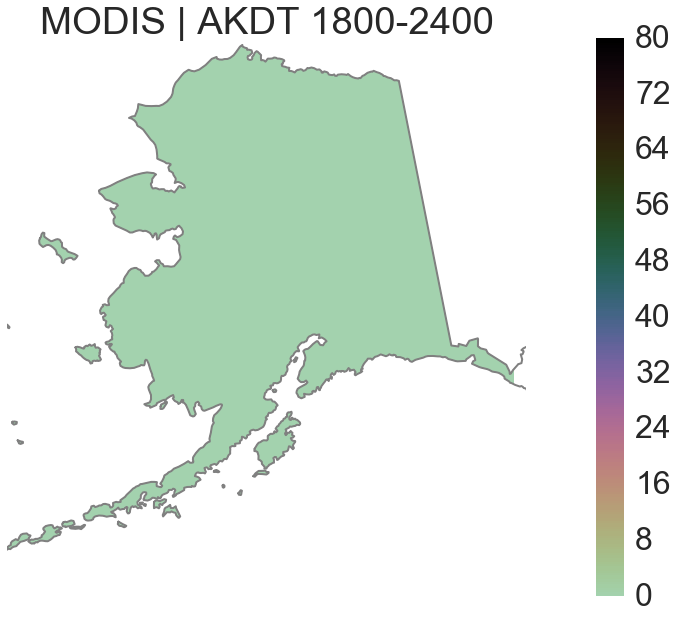

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
cmap = sns.cubehelix_palette(light=1, start=.6, as_cmap=True)
cmap = sns.cubehelix_palette(start=.5, rot=2, light=.75, dark=0, as_cmap=True)
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axis('off')
ax.set_xlim(-1000000.0, 1000000.0)
ax.set_ylim(250000, 2400000.0)
fireplot = ax.pcolormesh(Y, X, modAhists[3], cmap=cmap, vmin=0, vmax=80)
ax.set_title(modtitles[3])
plt.colorbar(fireplot)
for poly in multipolyAK:
    x, y = poly.boundary.xy
    ax.plot(x, y, color="grey", lw=2)
ax.add_patch(PolygonPatch(rest.difference(multipolyAK), facecolor='white', alpha=1) )

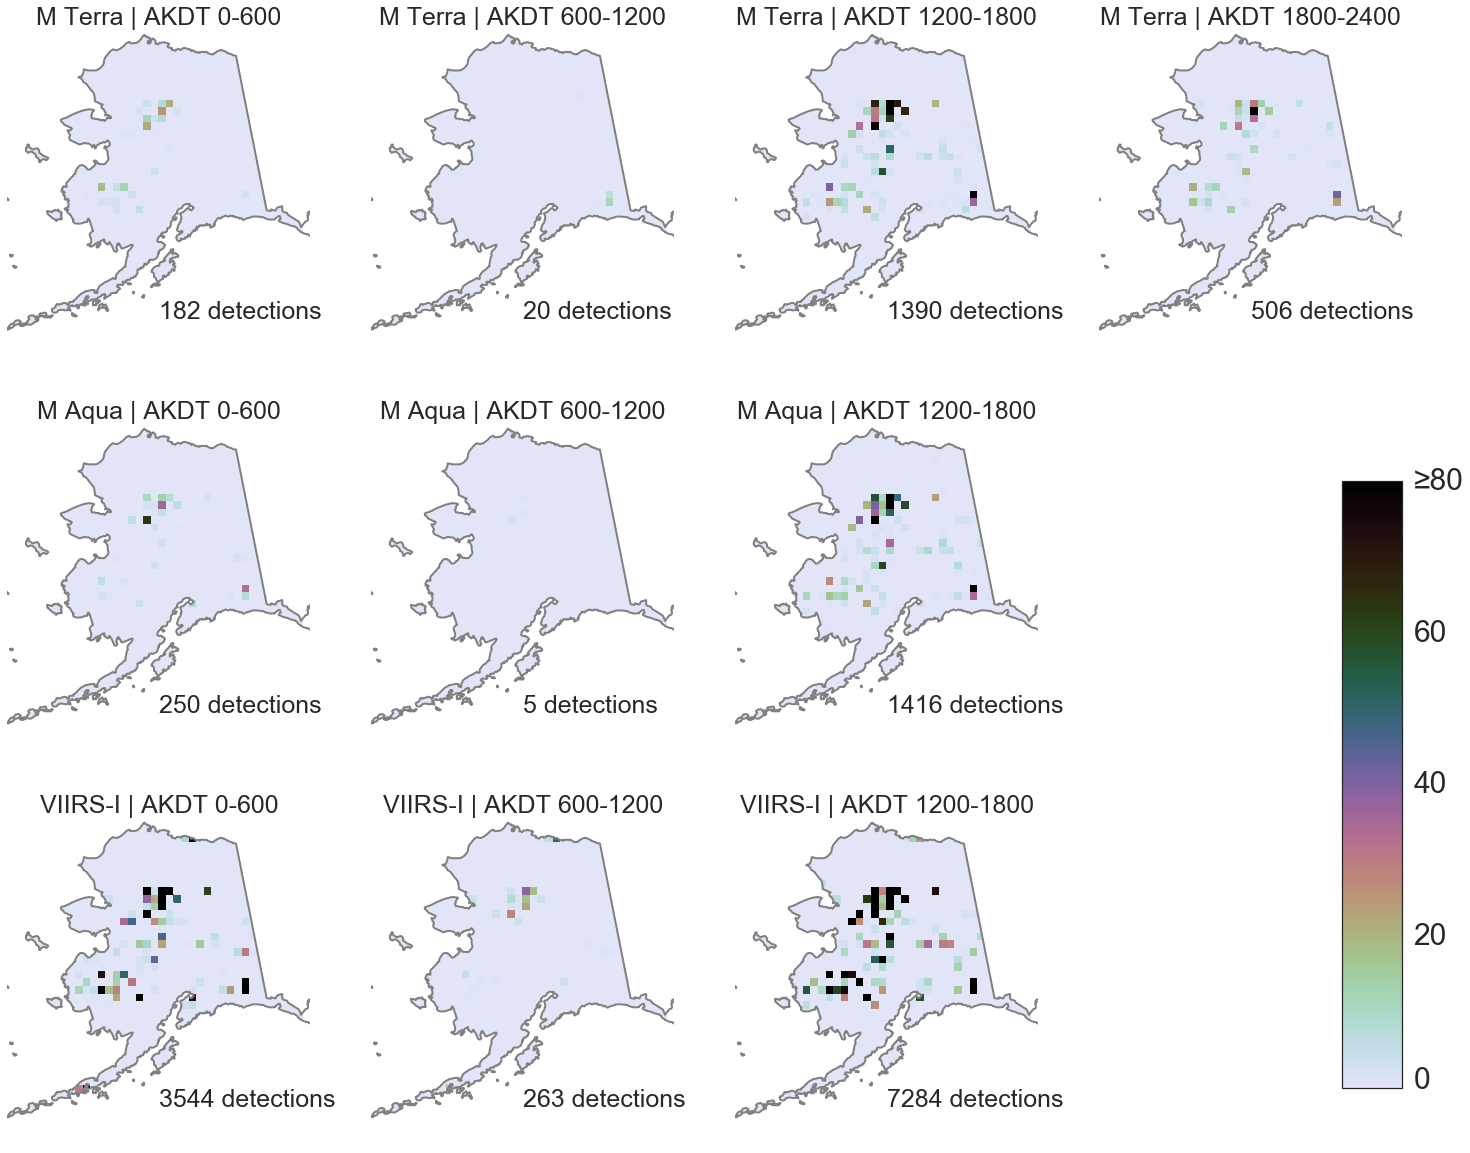

In [44]:
sns.set_style("white")
sns.set_context("poster", font_scale=1.3)
cmap = sns.cubehelix_palette(start=.5, rot=2, light=.9, dark=0, as_cmap=True)

fig, axs = plt.subplots(3, 4, figsize=(25, 20), sharex=True, sharey=True)
#fig.subplots_adjust(wspace = 0.05)

for idx, ax in enumerate(axs[0]):
    ax.set_aspect('equal')
    ax.set_xlim(-1000000.0, 1000000.0)
    ax.set_ylim(250000, 2400000.0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    ax.add_patch(PolygonPatch(rest.difference(multipolyAK), facecolor='white', alpha=1) )
    ax.pcolormesh(Y, X, modThists[idx], cmap=cmap, vmin=0, vmax=80)
    ax.set_title(modTtitles[idx])
    ax.text(0, 500000, modTcounts[idx] + ' detections')
    for poly in multipolyAK:
        x, y = poly.boundary.xy
        ax.plot(x, y, color="grey", lw=2)
for idx, ax in enumerate(axs[1][:-1]):
    ax.set_aspect('equal')
    ax.set_xlim(-1000000.0, 1000000.0)
    ax.set_ylim(250000, 2400000.0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    ax.add_patch(PolygonPatch(rest.difference(multipolyAK), facecolor='white', alpha=1) )
    ax.pcolormesh(Y, X, modAhists[idx], cmap=cmap, vmin=0, vmax=80)
    ax.set_title(modAtitles[idx])
    ax.text(0, 500000, modAcounts[idx] + ' detections')
    for poly in multipolyAK:
        x, y = poly.boundary.xy
        ax.plot(x, y, color="grey", lw=2)
for idx, ax in enumerate(axs[2][:-1]):
    ax.set_aspect('equal')
    ax.set_xlim(-1000000.0, 1000000.0)
    ax.set_ylim(250000, 2400000.0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    ax.add_patch(PolygonPatch(rest.difference(multipolyAK), facecolor='white', alpha=1) )
    im = ax.pcolormesh(Y, X, viirshists[idx], cmap=cmap, vmin=0, vmax=80)
    ax.set_title(viirstitles[idx])
    ax.text(0, 500000, viirscounts[idx] + ' detections')
    for poly in multipolyAK:
        x, y = poly.boundary.xy
        ax.plot(x, y, color="grey", lw=2)

axs[1][3].set_visible(False)    
axs[2][3].set_visible(False)        
cbar = fig.colorbar(im,  ax=[axs[1][3], axs[2][3]], fraction=.2, pad=0, aspect=10)
cbar.set_ticks([1, 20, 40, 60, 80])
cbar.set_ticklabels(['0', '20', '40', '60', u'≥80'])
cbar.ax.tick_params(labelsize=30)

In [47]:
fig.savefig(os.path.join(gisoutdir, "Fig07_LR.png"), dpi=150, bbox_inches='tight')

In [46]:
fig.savefig(os.path.join(gisoutdir, "Fig07.png"), dpi=300, bbox_inches='tight')

In [440]:
viirsIDF.groupby('akdtinterval').size()

akdtinterval
0-600        3544
1200-1800    7284
600-1200      263
dtype: int64

In [52]:
mod14DF.groupby(['SATELLITE', 'akdtinterval']).size()

SATELLITE  akdtinterval
Aqua       0-600            250
           1200-1800       1416
           600-1200           5
Terra      0-600            182
           1200-1800       1390
           1800-2400        506
           600-1200          20
dtype: int64